In [1]:
import torch 
from models import NONA_FT, NONA
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
from transformers import AutoTokenizer, AutoModel
from ft_cnn import RSNADataset
from ft_transformer import AdressoDataset
from utils import load_data_params, get_fold_indices
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torcheval.metrics.functional import mean_squared_error
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import sys
import pickle as pkl

/sc/arion/projects/pandeg01a/susmaa01/nona/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
device = torch.device('cpu')

dataset = 'adresso'
model_type = 'nona euclidean'
run = '03051120'
seed = 0
label = 'dx'

if dataset=='rsna':
    label = None


pred_sim = model_type.split(" ")
if len(pred_sim)==2:
    predictor_head = pred_sim[0]
    sim = pred_sim[1]
else:
    predictor_head= model_type 
    sim = None

if dataset == 'rsna':
    feature_extractor = resnet18(weights='DEFAULT')
elif dataset == 'adresso':
    feature_extractor = AutoModel.from_pretrained("distilbert-base-uncased")

model=NONA_FT(feature_extractor=feature_extractor, 
                        hl_sizes=[200,50], 
                        predictor=predictor_head, 
                        similarity=sim, 
                        task='binary', 
                        dtype=torch.float32
                        )                   

In [22]:
sft_weights = torch.load(f'results/{dataset}/models/{run}/{model_type}_{str(seed)}.pth', map_location=device)
model.load_state_dict(sft_weights)

<All keys matched successfully>

In [23]:
if dataset == 'rsna':
    task, data_df, fe, data_percentage, transform = load_data_params(dataset)
    idx_dict = get_fold_indices(dataset=dataset, data_df=data_df, seed=seed, data_percentage=data_percentage, keep_unused=True)
elif dataset == 'adresso':
    task, data_df, fe, tokenizer = load_data_params(dataset, label=label)
    idx_dict = get_fold_indices(dataset=dataset, label=label, data_df=data_df, seed=seed)
    

In [24]:
if dataset == 'rsna':
    def collate(batch):
        x, y = zip(*batch)
        x = torch.stack(x).to(device).to(torch.float32)
        y = torch.tensor(y, dtype=torch.float32, device=device)
        return x, y

    train_dataset = RSNADataset(idx_dict['train'], transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False, collate_fn=collate)

    unused_dataset = RSNADataset(idx_dict['unused'][: len(idx_dict['unused']) // 6], transform=transform, scaler=train_dataset.scaler)
    unused_loader = DataLoader(unused_dataset, batch_size=len(unused_dataset), shuffle=False, collate_fn=collate)

    test_dataset = RSNADataset(idx_dict['test'], transform=transform, scaler=train_dataset.scaler)
    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True, collate_fn=collate)


elif dataset == 'adresso':
    def collate_fn(batch):
        input_ids = torch.tensor([item["input_ids"] for item in batch])
        attention_mask = torch.tensor([item["attention_mask"] for item in batch])
        labels = torch.tensor([item["labels"] for item in batch], dtype=torch.float)

        return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}
    
    train_dataset = AdressoDataset(label=label, tokenizer=tokenizer, ids=idx_dict['train'])
    train_loader = DataLoader(train_dataset.get_dataset(), batch_size=train_dataset.len(), shuffle=True, collate_fn=collate_fn) # for use as neighbors with val and test

    val_dataset = AdressoDataset(label=label, tokenizer=tokenizer, ids=idx_dict['val'], scaler=train_dataset.scaler)
    val_loader = DataLoader(val_dataset.get_dataset(), batch_size=val_dataset.len(), shuffle=True, collate_fn=collate_fn)

    test_dataset = AdressoDataset(label=label, tokenizer=tokenizer, scaler=train_dataset.scaler)
    test_loader = DataLoader(test_dataset.get_dataset(), batch_size=test_dataset.len(), shuffle=True, collate_fn=collate_fn)

Map: 100%|██████████| 71/71 [00:00<00:00, 1349.61 examples/s]


In [25]:
if dataset == 'rsna':
    with torch.no_grad():
        for (X_train, y_train), (X_test, y_test) in zip(train_loader, test_loader): # one batch
            y_hat_train, train_embeddings = model(X_train, X_train, y_train, get_embeddings=True)
            y_hat_test, test_embeddings = model(X_test, X_train, y_train, get_embeddings=True)

elif dataset == 'adresso':
    with torch.no_grad():
        for train_batch, test_batch in zip(train_loader, test_loader):
            X_train = {key: val.to(device) for key, val in train_batch.items() if key!='labels'}
            y_train = train_batch['labels'].to(device)
            
            X_test = {key: val.to(device) for key, val in test_batch.items() if key!='labels'}
            y_test = test_batch['labels'].to(device)
            
            y_hat_train, train_embeddings = model(X_train, X_train, y_train, get_embeddings=True)
            y_hat_test, test_embeddings = model(X_test, X_train, y_train, get_embeddings=True)

In [26]:
with open(f"results/{dataset}/scores_{run}.pkl", "rb") as file:
    results = pkl.load(file=file)
    desc = results[0]
    scores_list = results[1:]
print(desc)

test_score = scores_list[seed][f'{model_type} mlp'][0]
test_score
    

200,50 dx label. auc score


0.5790985822677612

/sc/arion/projects/pandeg01a/susmaa01/nona/.venv/lib64/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/sc/arion/projects/pandeg01a/susmaa01/nona/.venv/lib64/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


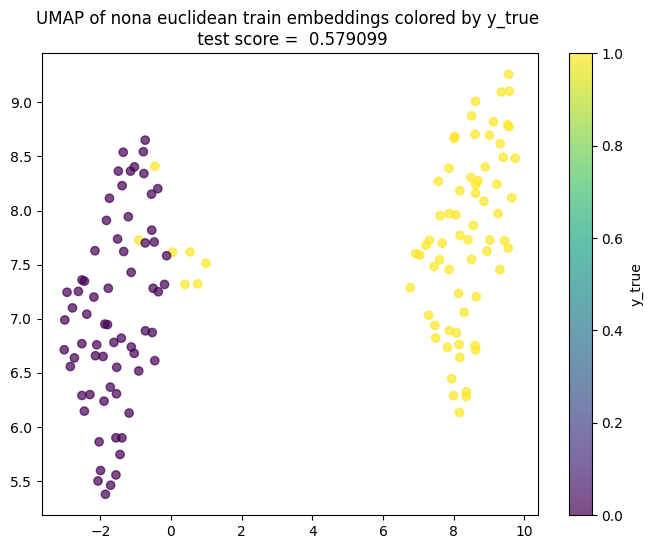

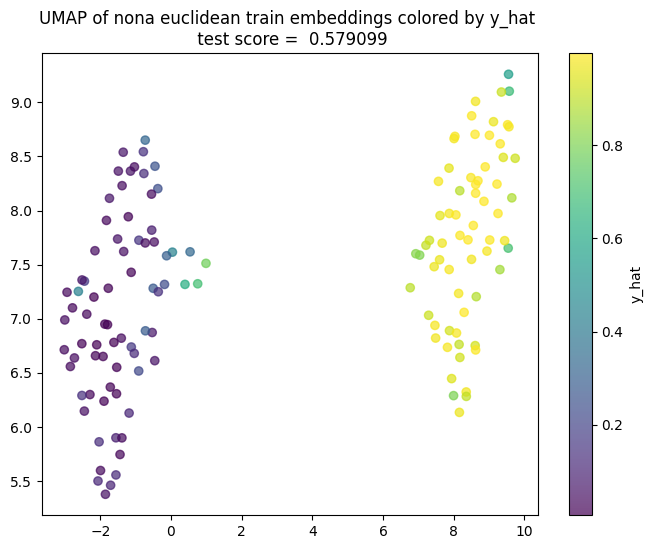

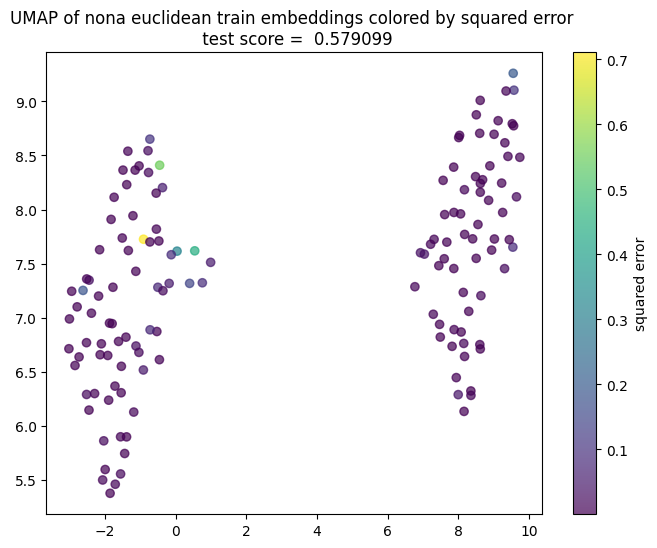

In [31]:
proj_dim = 2

embedding_set = 'train'
if embedding_set == 'train':
    embeddings = train_embeddings
    label_dict = {'y_true': y_train, 'y_hat': y_hat_train, 'squared error': (y_hat_train - y_train)**2}    
elif embedding_set == 'test':
    embeddings = test_embeddings
    label_dict = {'y_true': y_test, 'y_hat': y_hat_test, 'squared error': (y_hat_test - y_test)**2}

proj_type = 'umap'
if proj_type == 'tsne':
    proj = TSNE(n_components=proj_dim, random_state=42)
elif proj_type == 'pca':
    proj = PCA(n_components=proj_dim, random_state=42)
elif proj_type == 'umap':
    proj = UMAP(n_components=proj_dim, random_state=42)

reduced_embeddings = proj.fit_transform(embeddings)

for label_to_vis, y in label_dict.items():
    
    title = f"{proj_type.upper()} of {model_type} {embedding_set} embeddings colored by {label_to_vis} \n test score = {test_score : 4f}"
    
    fig = plt.figure(figsize=(8, 6))#, dpi=200)
    if proj_dim == 2:
        plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=y, cmap='viridis', alpha=0.7)
        plt.colorbar(label=label_to_vis)
        plt.title(title)

    elif proj_dim == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], reduced_embeddings[:, 2], c=y, cmap='viridis', alpha=0.7)
        fig.colorbar(ax.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], reduced_embeddings[:, 2], c=y, cmap='viridis', alpha=0.7), label=label_to_vis)
        ax.set_title(title)
    plt.show()

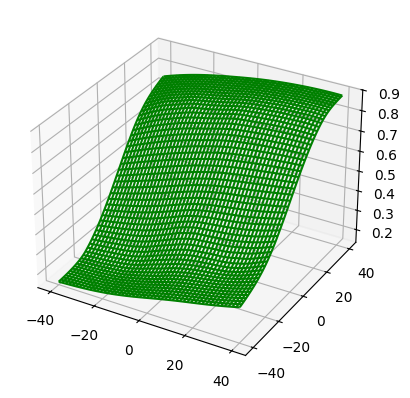

In [28]:
# Not the same as above. Outputs from above are with 50d NONA

nona = NONA(dtype=torch.float32, batch_norm=2)
grid_size = 500
scale = 40

x_grid = torch.linspace(-scale, scale, grid_size).to(torch.float32)
y_grid = torch.linspace(-scale, scale, grid_size).to(torch.float32)

X_test = torch.cartesian_prod(x_grid, y_grid)

Z = nona(X_test, torch.tensor(reduced_embeddings), y_train).reshape(grid_size,grid_size).detach()

X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot_wireframe(X_grid, Y_grid, Z, color ='green')

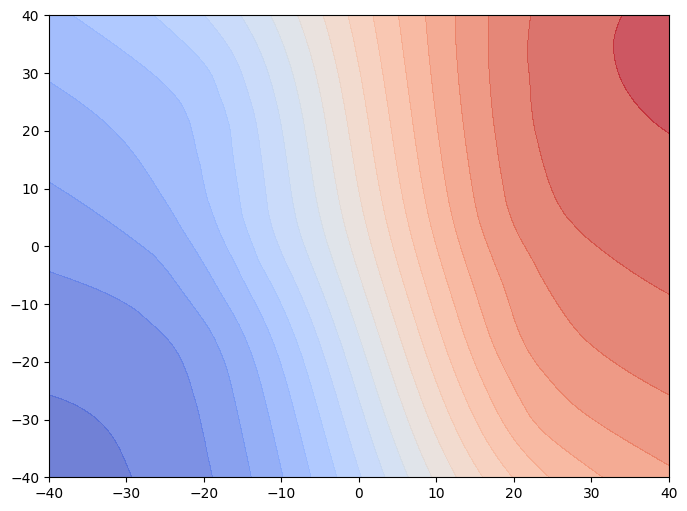

In [29]:
xx, yy = np.meshgrid(np.linspace(-scale, scale, grid_size), np.linspace(-scale, scale, grid_size))
grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

probabilities = nona(grid_points,  torch.tensor(reduced_embeddings), y_train).reshape(grid_size, grid_size).detach()

# Plot the heatmap using contourf
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, probabilities, levels=20, cmap="coolwarm", alpha=0.75)

plt.show()